In [1]:
from utils.data import Data
import numpy as np
import matplotlib.pyplot as plt
import rasterio
np.random.seed(7)

In [2]:
c_post_tiff_filename = "./Sergio/Images/JOR_C_Post.tif"
c_post_shp_filename = "./Sergio/Labels/JOR_C_Post.shp"

/home/ecology/.local/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


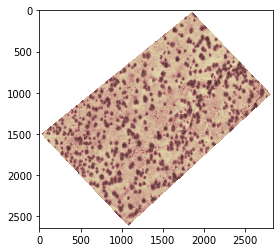

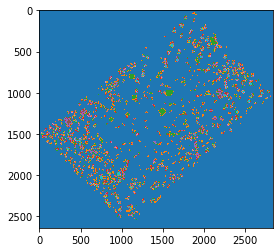

In [3]:
c_post_data = Data(c_post_tiff_filename, c_post_shp_filename, classes = ['Bare Ground','Graminoid','Shade', 'Shrub'])
c_post_tiff = c_post_data.read_tiff()
c_post_mask = c_post_data.get_mask(column="Classname", drop="Other")
c_post_data.view_tiff(c_post_tiff, channel=1)
c_post_data.view_mask(c_post_mask)

In [4]:
nil = np.sum(c_post_mask, axis=2) == 0
ground_truth = np.argmax(c_post_mask, axis=2)+1
ground_truth[nil] = 0
# Ground Truth classes
#   0 : nil
#   1 : bare ground
#   2 : gramanoid
#   3 : shade
#   4 : shrub

In [5]:
max_likelihood_file = "./Sergio/max_likelihood/JOR_C_Post_max_likelihood.tif"
max_likelihood_tiff = rasterio.open(max_likelihood_file)
max_likelihood_np = max_likelihood_tiff.read()

In [6]:
max_likelihood_np = np.squeeze(max_likelihood_np)
# Max likelihood classes
#   0 : background
#   1 : shrub
#   2 : gramanoid
#   3 : bare ground
#   4 : shade
#   5 : Others
max_likelihood_np[max_likelihood_np==4] = 30
max_likelihood_np[max_likelihood_np==1] = 4
max_likelihood_np[max_likelihood_np==3] = 1
max_likelihood_np[max_likelihood_np==30] = 3

In [7]:
random_forest_file = "./outputs/c_post_all.tif"
random_forest_tiff = rasterio.open(random_forest_file)
random_forest_np = random_forest_tiff.read()

In [8]:
random_forest_np = np.squeeze(random_forest_np)
from collections import Counter
Counter(random_forest_np.flatten())
# Random Forest classes
#   0 : nil
#   1 : bare ground
#   2 : gramanoid
#   3 : shade
#   4 : shrub
#   5 : background

Counter({1.0: 1112649, 2.0: 1434324, 3.0: 348124, 4.0: 666544, 5.0: 3941440})

In [9]:
def get_acc(true, pred, channel):
    pred[true == 0] = 0
    correct = np.sum((true == channel)*(pred==channel))
    total = np.sum(true==channel)
    return correct/total

def get_precision(true, pred, channel):
    pred[true == 0] = 0
    tp = np.sum((true == channel)*(pred==channel))
    fp = np.sum((true != channel)*(pred==channel))
    return tp/(tp+fp)

def get_recall(true, pred, channel):
    pred[true == 0] = 0
    tp = np.sum((true == channel)*(pred==channel))
    fn = np.sum((true == channel)*(pred!=channel))
    return tp/(tp+fn)

def get_fscore(true, pred, channel):
    pred[true == 0] = 0
    precision = get_precision(true, pred, channel)
    recall = get_recall(true, pred, channel)
    return 2*precision*recall/(precision+recall)

def get_acc_precision_recall_fscore(true, pred, channel):
    acc = get_acc(true, pred, channel)
    precision = get_precision(true, pred, channel)
    recall = get_recall(true, pred, channel)
    fscore = get_fscore(true, pred, channel)
    return round(acc, 4), round(precision, 4), round(recall, 4), round(fscore, 4)

In [10]:
print("Maximum Likelihood")
classes = ["bare ground", "gramanoid", "shade", "shrub"]
for i,label in enumerate(classes):
    print(f"\t{label}\t| Accuracy, Precision, Recall, FScore:{get_acc_precision_recall_fscore(ground_truth, max_likelihood_np, i+1)}")

Maximum Likelihood
	bare ground	| Accuracy, Precision, Recall, FScore:(0.9081, 0.6773, 0.9081, 0.7759)
	gramanoid	| Accuracy, Precision, Recall, FScore:(0.4083, 0.7156, 0.4083, 0.5199)
	shade	| Accuracy, Precision, Recall, FScore:(0.885, 0.8796, 0.885, 0.8823)
	shrub	| Accuracy, Precision, Recall, FScore:(0.9389, 0.9678, 0.9389, 0.9532)


In [11]:
print("Random Forest")
classes = ["bare ground", "gramanoid", "shade", "shrub"]
for i,label in enumerate(classes):
    print(f"\t{label}\t| Accuracy, Precision, Recall, FScore:{get_acc_precision_recall_fscore(ground_truth, random_forest_np, i+1)}")

Random Forest
	bare ground	| Accuracy, Precision, Recall, FScore:(0.6882, 0.6937, 0.6882, 0.6909)
	gramanoid	| Accuracy, Precision, Recall, FScore:(0.551, 0.4653, 0.551, 0.5046)
	shade	| Accuracy, Precision, Recall, FScore:(0.9033, 0.8491, 0.9033, 0.8753)
	shrub	| Accuracy, Precision, Recall, FScore:(0.8888, 0.9886, 0.8888, 0.9361)
